# Análisis de click en anuncios y descarga de app

**Proyecto Fin de Máster (Datascience). Universidad Rey Juan Carlos. Madrid**

Autor: Raúl Salazar

### Contenido
* Descripción del dataset.
* Análisis exploratorio.
* Análisis ponderado al tratarse de un dataset extremadamente desbalanceado
* Estudio de reducción de la dimensionalidad (PCA)
* Aplicación de técnicas para obtener la relevancia de cada atributo

_Instalación de librerías necesarias_

In [1]:
!pip install pandas
!pip install seaborn
!pip install plotly

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Data preparation

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os

#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

__Importación de datos__

In [3]:
#import first 10,000,000 rows of train and all test data
train = pd.read_csv('./input/train.csv', nrows=10000000)
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

ip  app  device  os  channel           click_time attributed_time  \
0   83230    3       1  13      379  2017-11-06 14:32:21             NaN   
1   17357    3       1  19      379  2017-11-06 14:33:34             NaN   
2   35810    3       1  13      379  2017-11-06 14:34:12             NaN   
3   45745   14       1  13      478  2017-11-06 14:34:52             NaN   
4  161007    3       1  13      379  2017-11-06 14:35:08             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0

In [5]:
test.head()

click_id      ip  app  device  os  channel           click_time
0         0    5744    9       1   3      107  2017-11-10 04:00:00
1         1  119901    9       1   3      466  2017-11-10 04:00:00
2         2   72287   21       1  19      128  2017-11-10 04:00:00
3         3   78477   15       1  13      111  2017-11-10 04:00:00
4         4  123080   12       1  13      328  2017-11-10 04:00:00

#### Variables definitions

| Variable                | Definition                                                                            |
|-------------------------|---------------------------------------------------------------------------------------|
| ip                      | ip address of click                                                                   |
| app                     | app id for marketing                                                                  |
| device                  | device type id of user mobile phone (e.g., iphone 6 plus,huawei mate 7, etc.)         |
| os                      | os version id of user mobile phone                                                    |
| channel                 | channel id of mobile ad publisher                                                     |
| click_time              | timestamp of click (UTC)                                                              |
| attributed_time         |if user download the app for after clicking an ad, this is the time of the app download|
| is_attributed           | the target that is to be predicted, indicating the app was downloaded                 |

_Definiendo el tipo de las variables_

In [6]:
# define some columns as categorical type
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

In [7]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

In [8]:
train.describe()

ip         app      device          os     channel  \
count   10000000.0  10000000.0  10000000.0  10000000.0  10000000.0   
unique     68740.0       332.0       940.0       292.0       170.0   
top        73516.0        12.0         1.0        19.0       245.0   
freq       51711.0   1291185.0   9381146.0   2410148.0    793105.0   
first          NaN         NaN         NaN         NaN         NaN   
last           NaN         NaN         NaN         NaN         NaN   

                 click_time      attributed_time  is_attributed  
count              10000000                18717     10000000.0  
unique                29943                15698            2.0  
top     2017-11-06 16:05:10  2017-11-06 23:36:23            0.0  
freq                   1261                    6      9981283.0  
first   2017-11-06 14:32:21  2017-11-06 16:00:47            NaN  
last    2017-11-07 00:12:03  2017-11-07 15:59:53            NaN

_Obtención de valores únicos de cada variable_

In [9]:
# counts unique elements 
t_unique = train.nunique()
t_unique

ip                 68740
app                  332
device               940
os                   292
channel              170
click_time         29943
attributed_time    15698
is_attributed          2
dtype: int64

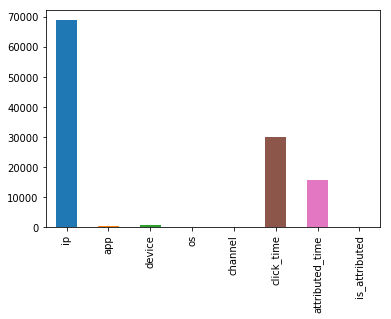

In [10]:
t_unique.plot(kind='bar')

In [11]:
#double check that 'attributed_time' is not Null for all values that resulted in download (i.e. is_attributed == 1)
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

attributed_time  is_attributed
count                 18717        18717.0
unique                15698            1.0
top     2017-11-06 23:36:23            1.0
freq                      6        18717.0
first   2017-11-06 16:00:47            NaN
last    2017-11-07 15:59:53            NaN

_Para 10.000.000 de clicks existen 18717 de descargas, por tanto 0,19% de las filas corresponden a descargas..._  

In [12]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

click_id          ip         app      device          os  \
count   18790469.0  18790469.0  18790469.0  18790469.0  18790469.0   
unique  18790469.0     93936.0       417.0      1985.0       395.0   
top     18790468.0      5348.0         9.0         1.0        19.0   
freq           1.0    182522.0   2872176.0  17360269.0   4334532.0   
first          NaN         NaN         NaN         NaN         NaN   
last           NaN         NaN         NaN         NaN         NaN   

           channel           click_time  
count   18790469.0             18790469  
unique       178.0                21603  
top          107.0  2017-11-10 09:00:10  
freq     1214650.0                 1466  
first          NaN  2017-11-10 04:00:00  
last           NaN  2017-11-10 15:00:00

### Estudio de variable IP

_Descripción de la variable IP_

In [13]:
train.ip.describe()

count     10000000
unique       68740
top          73516
freq         51711
Name: ip, dtype: int64

_Estudio de correlación con respecto a la variable ip_

In [14]:
# correlation ip with is_attributed
np.corrcoef(train.ip, train.is_attributed)[0, 1]

0.028964283176045946

In [15]:
# correlation ip with app
np.corrcoef(train.ip, train.app)[0, 1]

0.0066379653936350161

In [16]:
# correlation ip with device
np.corrcoef(train.ip, train.device)[0, 1]

-0.0046861310299617844

In [17]:
# correlation ip with os
np.corrcoef(train.ip, train.os)[0, 1]

-0.0038159937304018485

In [18]:
# correlation ip with channel
np.corrcoef(train.ip, train.channel)[0, 1]

0.0060746882969848802

_Uniques values_

In [19]:
len(set(train.ip))

68740

_Ips que más aparecen y número de apariciones de las mismas_

In [20]:
# unique ip counts 
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

ip  counts
0   73516   51711
1   73487   51215
2    5314   35073
3    5348   35004
4   53454   25381
5  105560   23289
6  100275   23070
7  114276   22774
8  201182   22719
9  105475   22047

_Mostrando Ips provenientes de clicks que suponen la descarga_

In [21]:
# counts rows ip with is_attributed == 1
train[train['is_attributed']==1].ip.describe()[0]

18717

In [22]:
train[train['is_attributed']==1].ip.describe()[0]/10000000

0.0018717

_Por tanto se observa que el número de IP cuyas apps son descargadas son infimas_

**Por tanto se trata de un dataset extremadamente desbalanceado**

In [23]:
# union betweetn train and test, with ip unique counts
train_union= train.merge(temp, on='ip', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


_Comprobamos cuantas veces las ips son descargadas, en el conjunto de clicks_

In [24]:
# unique counts ip with is_attributed == 1
temp_isa1 = train_union[train_union['is_attributed']==1]['ip'].value_counts().reset_index(name='counts')
temp_isa1.columns = ['ip', 'counts']
temp_isa1[:10]

ip  counts
0   73487      56
1   73516      54
2    5314      26
3  201182      25
4    5348      24
5  100275      23
6  105475      22
7  105560      16
8   44744      15
9  147957      14

In [25]:
# unique ip counts 
len(set(temp_isa1.ip))

train_union['is_attributed']=train_union['is_attributed'].astype('int')

#### Representación de los resultados obtenidos con respecto a la IP (tabla y gráfica)

In [26]:
# calculated prop_downloaded by each ip
train_special = train_union.groupby(['ip','counts'])["is_attributed"].sum().reset_index(name="sum")
train_special['prop_downloaded'] = train_special['sum'] / train_special['counts']

represent_graphic = train_special.sort_values(['counts'],ascending=False).head(300).reset_index()
represent_graphic.head()

index     ip  counts  sum  prop_downloaded
0  16011  73516   51711   54         0.001044
1  16004  73487   51215   56         0.001093
2   1161   5314   35073   26         0.000741
3   1172   5348   35004   24         0.000686
4  11714  53454   25381    3         0.000118

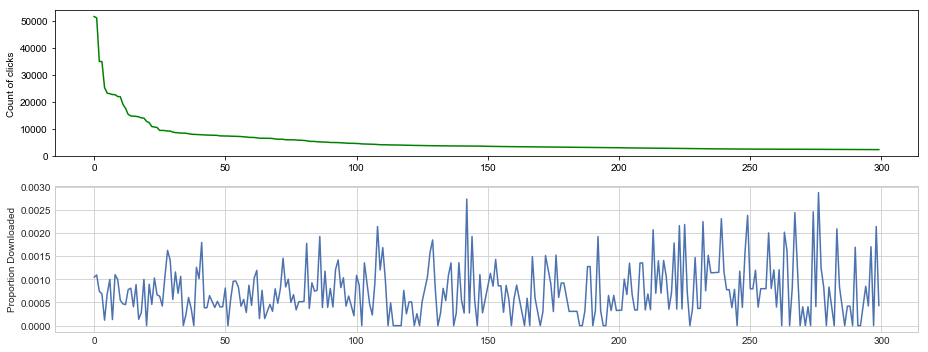

In [27]:
# Visualize graphics of clicks and props downloaded
represent_graphic_count = pd.Series(data=np.array(represent_graphic['counts']), index=represent_graphic.index)
represent_graphic_downloaded = pd.Series(data=np.array(represent_graphic['prop_downloaded']), index=represent_graphic.index)

plt.figure(1)

plt.subplot(211) #creamos la primera figura
represent_graphic_count.plot(figsize=(13, 5), color ='g') #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.xlabel('') #quitamos el nombre por defecto del eje x
plt.ylabel('Count of clicks') #añadimos el nombre del eje y


plt.subplot(212) #creamos la segunda figura
represent_graphic_downloaded.plot(figsize=(13, 5)) #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.ylabel('Proportion Downloaded') #añadimos el nombre del eje y

plt.tight_layout()
plt.show()



_Representación con histograma de la variable IP_

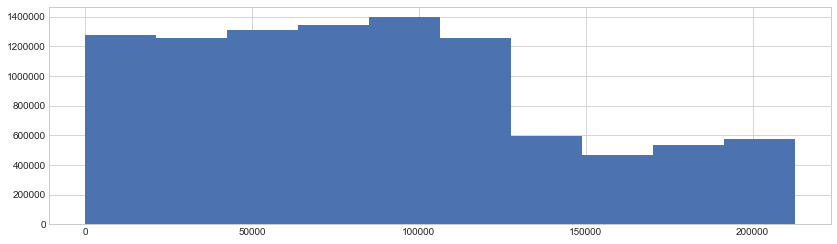

In [28]:
train['ip'].hist(figsize=[14,4])

### Estudio de variable App

_Descripción de la variable_

In [29]:
train.app.describe()

count     10000000
unique         332
top             12
freq       1291185
Name: app, dtype: int64

_Estudio de correlacion con respecto a la variable objetivo_

In [30]:
# correlation app with is_attributed
np.corrcoef(train.app, train.is_attributed)[0, 1]

0.049099330673343496

*Vamos a intentar cuantas veces se hace click en cada aplicación, y cual es la aplicación más demandada*

In [31]:
# counts clicks grouping by app
temp_app = train['app'].value_counts().reset_index(name='counts')
temp_app.columns = ['app', 'counts']
temp_app[:10].sort_values(['counts'],ascending=False)

app   counts
0  12  1291185
1   2  1202534
2  15  1181585
3   3  1170412
4   9   966839
5  18   917820
6  14   507491
7   1   391508
8   8   364361
9  21   223823

In [32]:
# description of app variable to clicks of downloaded app
train[train['is_attributed']==1].app.describe()

count     18717
unique      133
top          19
freq       5429
Name: app, dtype: int64

*Por tanto algo más de 1/3 de aplicaciones son descargadas*

In [33]:
# union of train with count of app
train_app= train_union.merge(temp_app, on='app', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


_Representación de los resultados (tabla y gráfica)_

In [34]:
# calculating prop downloded by app
train_specialapp = train_app.groupby(['app','counts_y'])["is_attributed"].sum().reset_index(name="sum")
train_specialapp['prop_downloaded'] = train_specialapp['sum'] / train_specialapp['counts_y']
represent_graphicapp = train_specialapp.sort_values(['counts_y','prop_downloaded'],ascending=False).head(300).reset_index()
represent_graphicapp.head()

index app  counts_y  sum  prop_downloaded
0     12  12   1291185  181         0.000140
1      2   2   1202534  467         0.000388
2     15  15   1181585  327         0.000277
3      3   3   1170412  737         0.000630
4      9   9    966839  840         0.000869

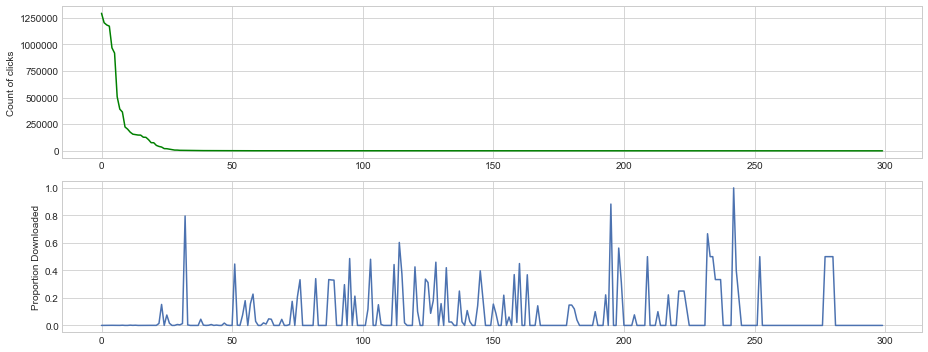

In [35]:
# Graphics of clicks counts with prop downloaded grouped by app
represent_graphic_count = pd.Series(data=np.array(represent_graphicapp['counts_y']), index=represent_graphic.index)
represent_graphic_downloaded = pd.Series(data=np.array(represent_graphicapp['prop_downloaded']), index=represent_graphic.index)

plt.figure(1)

plt.subplot(211) #creamos la primera figura
represent_graphic_count.plot(figsize=(13, 5), color ='g') #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.xlabel('') #quitamos el nombre por defecto del eje x
plt.ylabel('Count of clicks') #añadimos el nombre del eje y


plt.subplot(212) #creamos la segunda figura
represent_graphic_downloaded.plot(figsize=(13, 5)) #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.ylabel('Proportion Downloaded') #añadimos el nombre del eje y

plt.tight_layout()
plt.show()



_Representación con histograma de la variable APP_

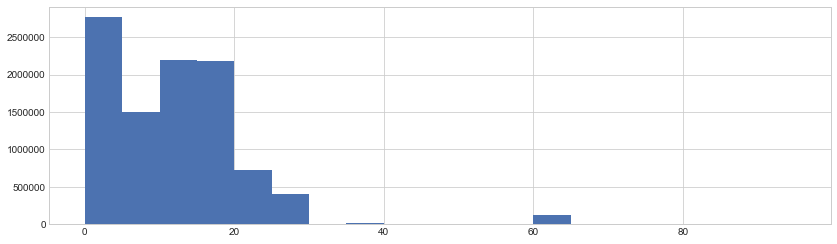

In [36]:
bin_values = np.arange(start=0, stop=100, step=5)
train['app'].hist(bins=bin_values, figsize=[14,4])

### Estudio de variable device

_Descripción de la variable_

In [37]:
train.device.describe()

count     10000000
unique         940
top              1
freq       9381146
Name: device, dtype: int64

_Estudio de la correlación en relación a la variable objetivo_

In [38]:
# correlation device with is_attributed
np.corrcoef(train.device, train.is_attributed)[0, 1]

-1.7976387648516072e-05

_Número de vecez que aparece cada dispositivo en nuestro dataset_

In [39]:
# counts clicks grouping by device
temp_dev = train['device'].value_counts().reset_index(name='counts')
temp_dev.columns = ['device', 'counts_z']
temp_dev[:10].sort_values(['counts_z'],ascending=False)

device  counts_z
0      1   9381146
1      2    456617
2   3032    104393
3      0     46476
4     59      1618
5     40       462
6      6       458
7     16       334
8     18       247
9     33       204

In [40]:
# description of device to downloaded clicks
train[train['is_attributed']==1].device.describe()

count     18717
unique      438
top           1
freq      12437
Name: device, dtype: int64

In [41]:
# union of train with device
train_dev= train_union.merge(temp_dev, on='device', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


_Representación de resultados (gráfica y tabla)_

In [42]:
# calculating props downloaded grouped by device
train_specialdev = train_dev.groupby(['app','counts_z'])["is_attributed"].sum().reset_index(name="sum")
train_specialdev['prop_downloaded'] = train_specialdev['sum'] / train_specialdev['counts_z']
represent_graphicdev = train_specialdev.sort_values(['counts_z','prop_downloaded'],ascending=False).head(300).reset_index()
represent_graphicdev.head()

index app  counts_z   sum  prop_downloaded
0    204  35   9381146  3172         0.000338
1    195  29   9381146  1478         0.000158
2     54   9   9381146   838         0.000089
3     34   3   9381146   726         0.000077
4     58  10   9381146   600         0.000064

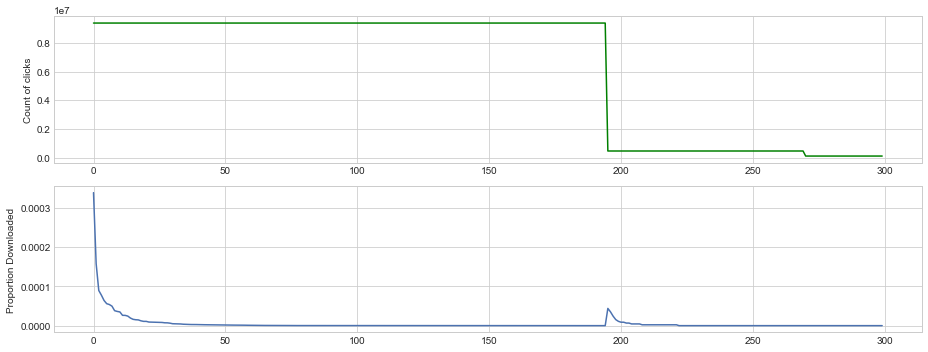

In [43]:
# Graphical prop downloaded by device
represent_graphic_count = pd.Series(data=np.array(represent_graphicdev['counts_z']), index=represent_graphic.index)
represent_graphic_downloaded = pd.Series(data=np.array(represent_graphicdev['prop_downloaded']), index=represent_graphic.index)

plt.figure(1)

plt.subplot(211) #creamos la primera figura
represent_graphic_count.plot(figsize=(13, 5), color ='g') #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.xlabel('') #quitamos el nombre por defecto del eje x
plt.ylabel('Count of clicks') #añadimos el nombre del eje y


plt.subplot(212) #creamos la segunda figura
represent_graphic_downloaded.plot(figsize=(13, 5)) #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.ylabel('Proportion Downloaded') #añadimos el nombre del eje y

plt.tight_layout()
plt.show()

_Representación gráfica variable device_

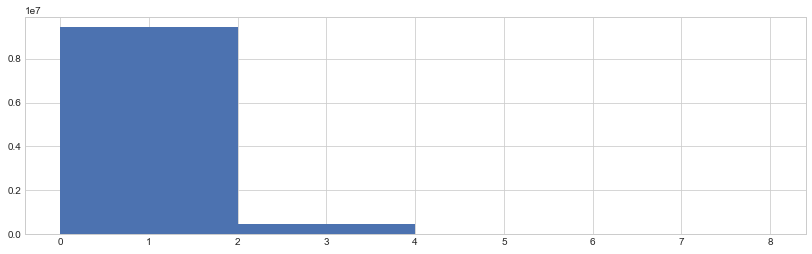

In [44]:
bin_values = np.arange(start=0, stop=10, step=2)
train['device'].hist(bins=bin_values, figsize=[14,4])

### Estudio de variable OS

_Descripción de la variable_

In [45]:
train.os.describe()

count     10000000
unique         292
top             19
freq       2410148
Name: os, dtype: int64

_Estudio de correlación con la variable objetivo: isattributed_

In [46]:
# correlation os with is_attributed
np.corrcoef(train.os, train.is_attributed)[0, 1]

-0.0021458221986519342

In [47]:
# num of clicks by os
temp_os = train['os'].value_counts().reset_index(name='counts')
temp_os.columns = ['os', 'counts_a']
temp_os[:10].sort_values(['counts_a'],ascending=False)

os  counts_a
0  19   2410148
1  13   2199778
2  17    531695
3  18    483602
4  22    365576
5  10    285907
6   8    279549
7   6    242799
8   9    239377
9  25    232143

In [48]:
# description of os to downloaded app
train[train['is_attributed']==1].os.describe()

count     18717
unique       67
top          19
freq       3588
Name: os, dtype: int64

In [49]:
# union of os count with train dataframe
train_os= train_union.merge(temp_os, on='os', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


_Representación de los resultados ( gráfica y tabla )_

In [50]:
train_specialos = train_os.groupby(['os','counts_a'])["is_attributed"].sum().reset_index(name="sum")
train_specialos['prop_downloaded'] = train_specialos['sum'] / train_specialos['counts_a']
represent_graphicapp2 = train_specialos.sort_values(['counts_a','prop_downloaded'],ascending=False).head(300).reset_index()
represent_graphicapp2.head()

index  os  counts_a   sum  prop_downloaded
0     19  19   2410148  3588         0.001489
1     13  13   2199778  2795         0.001271
2     17  17    531695   614         0.001155
3     18  18    483602   539         0.001115
4     22  22    365576   632         0.001729

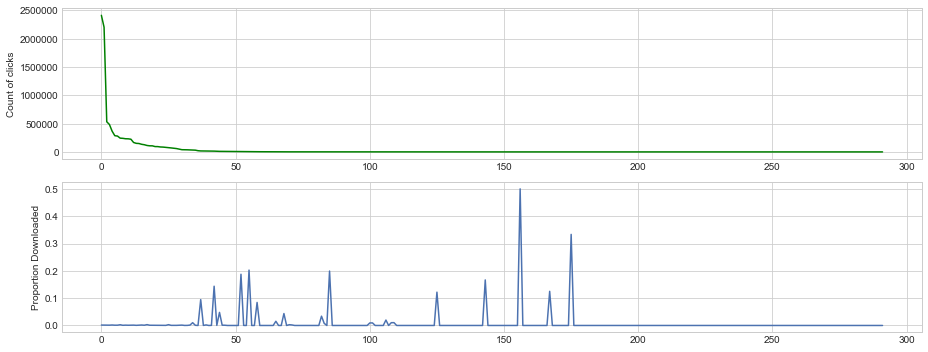

In [51]:
# graphic representation of clicks and prop of downloaded grouped by os
represent_graphic_c = pd.Series(data=np.array(represent_graphicapp2['counts_a']), index=represent_graphicapp2.index)
represent_graphic_d = pd.Series(data=np.array(represent_graphicapp2['prop_downloaded']), index=represent_graphicapp2.index)

plt.figure(1)

plt.subplot(211) #creamos la primera figura
represent_graphic_c.plot(figsize=(13, 5), color ='g') #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.xlabel('') #quitamos el nombre por defecto del eje x
plt.ylabel('Count of clicks') #añadimos el nombre del eje y


plt.subplot(212) #creamos la segunda figura
represent_graphic_d.plot(figsize=(13, 5)) #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.ylabel('Proportion Downloaded') #añadimos el nombre del eje y

plt.tight_layout()
plt.show()

_Representación con histograma de la variable OS_

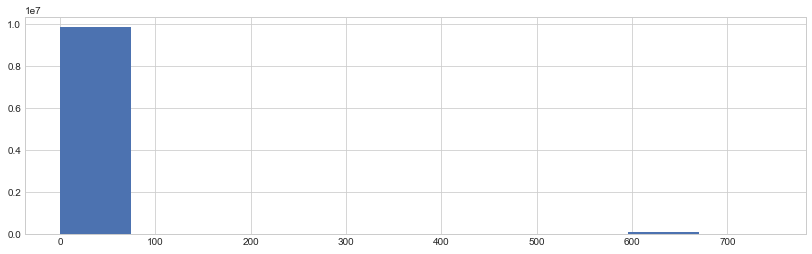

In [52]:
train['os'].hist( figsize=[14,4])

### Estudio de variable channel

_Descripción de la variable_

In [53]:
train.channel.describe()

count     10000000
unique         170
top            245
freq        793105
Name: channel, dtype: int64

_Estudio de correlación con respecto a la variable objetivo_

In [54]:
# correlation channel with downloaded app
np.corrcoef(train.channel, train.is_attributed)[0, 1]

-0.0097471802541404268

_Número de apariciones de cada canal_

In [55]:
# num of clicks by channels
temp_ch = train['channel'].value_counts().reset_index(name='counts')
temp_ch.columns = ['channel', 'counts_b']
temp_ch[:10].sort_values(['counts_b'],ascending=False)

channel  counts_b
0     245    793105
1     134    630888
2     259    469845
3     477    412559
4     121    402226
5     107    388035
6     145    348862
7     153    296832
8     205    279720
9     178    269720

In [56]:
# Description channel of click downloaded apps
train[train['is_attributed']==1].channel.describe()

count     18717
unique      138
top         213
freq       5525
Name: channel, dtype: int64

In [57]:
train_ch= train_union.merge(temp_ch, on='channel', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


_Representación de número de descargas y apariciones de cada canal en nuestro dataset (Gráfico y tabla)_

In [58]:
# Description de proportion of download grouping by channel
train_specialch = train_ch.groupby(['channel','counts_b'])["is_attributed"].sum().reset_index(name="sum")
train_specialch['prop_downloaded'] = train_specialch['sum'] / train_specialch['counts_b']
represent_graphicapp3 = train_specialch.sort_values(['counts_b','prop_downloaded'],ascending=False).reset_index()
represent_graphicapp3.head()

index channel  counts_b  sum  prop_downloaded
0     71     245    793105   83         0.000105
1     34     134    630888  352         0.000558
2     75     259    469845  307         0.000653
3    156     477    412559   30         0.000073
4     25     121    402226  130         0.000323

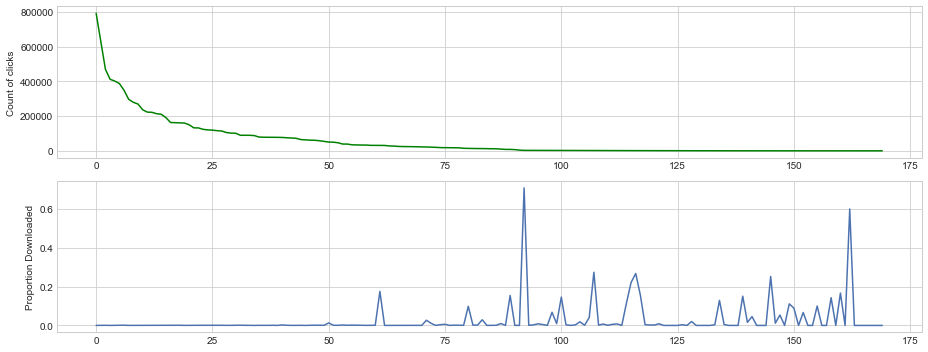

In [59]:
represent_graphic_c = pd.Series(data=np.array(represent_graphicapp3['counts_b']), index=represent_graphicapp3.index)
represent_graphic_d = pd.Series(data=np.array(represent_graphicapp3['prop_downloaded']), index=represent_graphicapp3.index)

plt.figure(1)

plt.subplot(211) #creamos la primera figura
represent_graphic_c.plot(figsize=(13, 5), color ='g') #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.xlabel('') #quitamos el nombre por defecto del eje x
plt.ylabel('Count of clicks') #añadimos el nombre del eje y


plt.subplot(212) #creamos la segunda figura
represent_graphic_d.plot(figsize=(13, 5)) #creamos el gráfico
sns.set_style('whitegrid') #establecemos el estilo de cuadricula
sns.set_palette('deep',1) #establecemos el color de la serie temporal en el gráfico
plt.ylabel('Proportion Downloaded') #añadimos el nombre del eje y

plt.tight_layout()
plt.show()

_Representación mediante histograma_

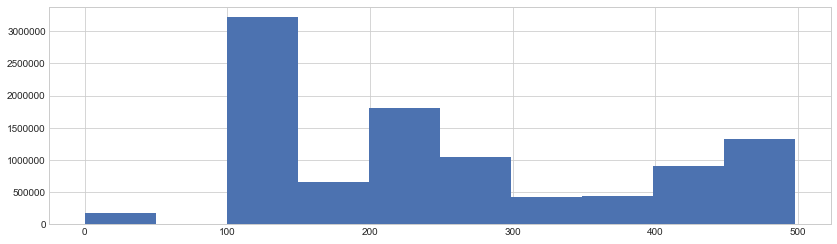

In [60]:
train['channel'].hist( figsize=[14,4])

Por tanto, parece que las variables que nos proporciona una mayor correlación son: ip y app

## Realizando comprobaciones con respecto a la variable tiempo de click

In [61]:
# Loading Sample train dataset to study times of click and app download
train_smp = pd.read_csv('./input/train_sample.csv')

In [62]:
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

_Estudio de horas de mayor actividad_

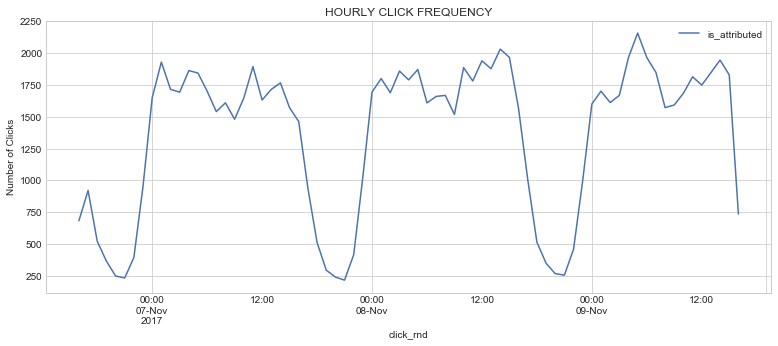

In [63]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot(figsize=(13, 5))
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');


_¿Podemos definir un patrón por hora?_

_Representación del número de clicks por hora_

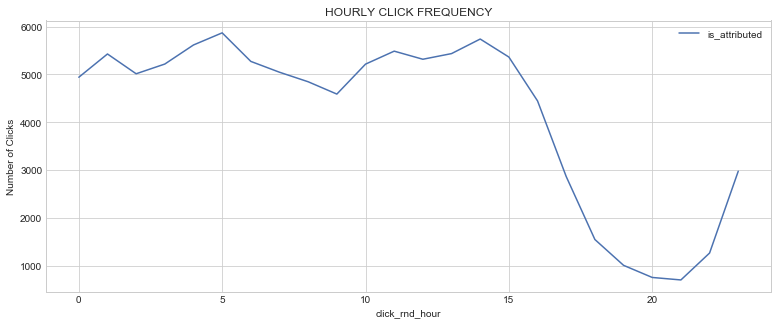

In [64]:
train_smp['click_rnd_hour']=train_smp['click_rnd'].dt.hour  

#check for hourly patterns
train_smp[['click_rnd_hour','is_attributed']].groupby(['click_rnd_hour'], as_index=True).count().plot(figsize=(13, 5))
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

_Representación de la proporción de descargas por hora_

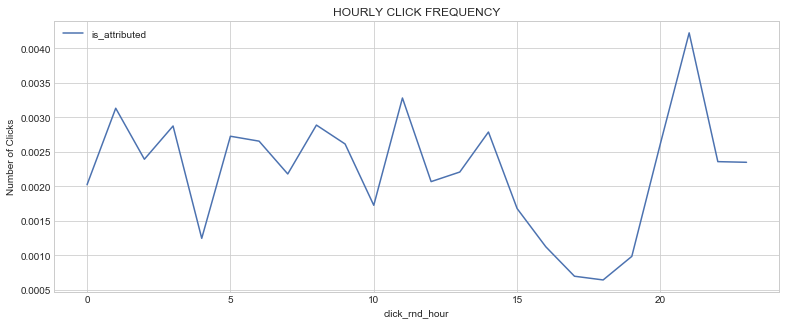

In [65]:
#check for hourly patterns
train_smp[['click_rnd_hour','is_attributed']].groupby(['click_rnd_hour'], as_index=True).mean().plot(figsize=(13, 5))
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

**Horas con mas click y valores de conversión**

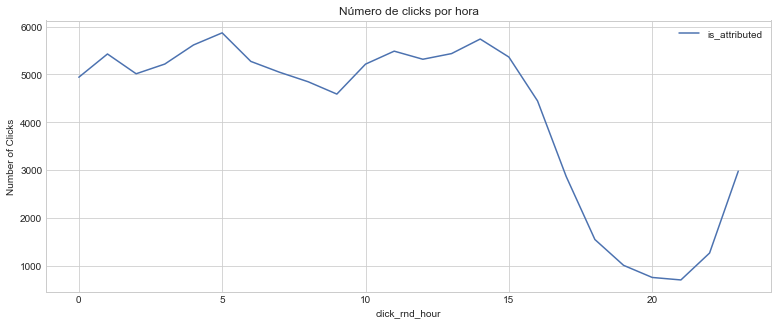

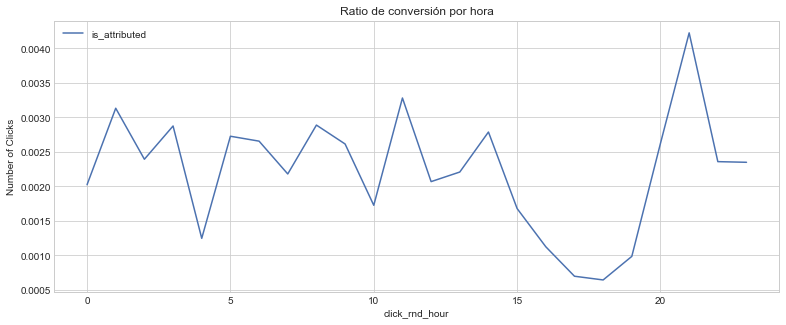

In [66]:
train_smp[['click_rnd_hour','is_attributed']].groupby(['click_rnd_hour'], as_index=True).count().plot(figsize=(13, 5))
plt.title('Número de clicks por hora');
plt.ylabel('Number of Clicks');


train_smp[['click_rnd_hour','is_attributed']].groupby(['click_rnd_hour'], as_index=True).mean().plot(figsize=(13, 5))
plt.title('Ratio de conversión por hora');
plt.ylabel('Number of Clicks');

plt.show()

_Representación en barplot del número de descargas por hora_

In [67]:
train_smp['ratio_conversion'] = train_smp[['click_rnd_hour','is_attributed']].groupby(['click_rnd_hour'], as_index=True).mean()

Text(0,0.5,'Número de viajes')

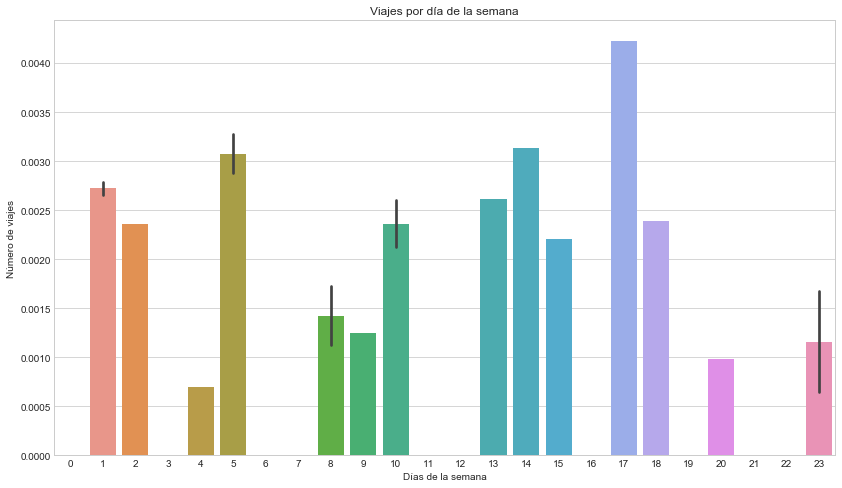

In [68]:
plt.figure(figsize=(14, 8)) #establecemos el tamaño de la gráfica
sns.barplot(x='click_rnd_hour', y='ratio_conversion', data=train_smp) #creamos la gráfica
plt.title('Viajes por día de la semana') #añadimos el título de gráfico
plt.xlabel('Días de la semana') #añadimos el nombre del eje x
plt.ylabel('Número de viajes') #añadimos el nombre del eje y

*Parece por tanto que existe cierta relación entre los clicks y el ratio de descarga de ambas gráficas*

#### Observando la variable attribute_time

In [69]:
# Calculating time between clicking on the ad and downloading the app
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']

# Showing 15 first rows
train_smp[train_smp['is_attributed']==1][:15]

ip  app  device  os  channel          click_time  \
284   224120   19       0  29      213 2017-11-08 02:22:13   
481   272894   10       1   7      113 2017-11-08 06:10:05   
1208   79001   19       0   0      213 2017-11-07 09:54:22   
1341  131029   19       0   0      343 2017-11-09 10:58:46   
1412   40352   19       0   0      213 2017-11-07 22:19:03   
1666   48733   35       1  18      274 2017-11-07 12:25:50   
1771  330861   35       1  22       21 2017-11-08 18:54:44   
1917  309576    5       1  32      113 2017-11-09 08:47:51   
3914  220571   71       1  25        3 2017-11-08 04:35:21   
3992  240051   35       1  19       21 2017-11-08 08:07:13   
4300  110652   19      16   0      213 2017-11-09 08:15:34   
4424  252612    5       1  31      113 2017-11-07 20:21:11   
4564   48072   19      21  24      213 2017-11-07 05:17:29   
4603   12506   62       1  19       21 2017-11-08 05:56:57   
4607  184467   35       1  30      274 2017-11-07 22:29:06   

         attributed_time  is_attributed           click_rnd  click_rnd_hour  \
284  2017-11-08 02:22:38              1 2017-11-08 02:00:00               2   
481  2017-11-08 06:10:37              1 2017-11-08 06:00:00               6   
1208 2017-11-07 11:59:05              1 2017-11-07 10:00:00              10   
1341 2017-11-09 11:52:01              1 2017-11-09 11:00:00              11   
1412 2017-11-08 01:55:02              1 2017-11-07 22:00:00              22   
1666 2017-11-07 13:10:30              1 2017-11-07 12:00:00              12   
1771 2017-11-08 22:39:52              1 2017-11-08 19:00:00              19   
1917 2017-11-09 08:47:55              1 2017-11-09 09:00:00               9   
3914 2017-11-08 04:37:46              1 2017-11-08 05:00:00               5   
3992 2017-11-08 09:46:42              1 2017-11-08 08:00:00               8   
4300 2017-11-09 09:30:19              1 2017-11-09 08:00:00               8   
4424 2017-11-07 20:21:42              1 2017-11-07 20:00:00              20   
4564 2017-11-07 06:49:01              1 2017-11-07 05:00:00               5   
4603 2017-11-08 08:56:58              1 2017-11-08 06:00:00               6   
4607 2017-11-08 00:16:14              1 2017-11-07 22:00:00              22   

      ratio_conversion timePass  
284                NaN 00:00:25  
481                NaN 00:00:32  
1208               NaN 02:04:43  
1341               NaN 00:53:15  
1412               NaN 03:35:59  
1666               NaN 00:44:40  
1771               NaN 03:45:08  
1917               NaN 00:00:04  
3914               NaN 00:02:25  
3992               NaN 01:39:29  
4300               NaN 01:14:45  
4424               NaN 00:00:31  
4564               NaN 01:31:32  
4603               NaN 03:00:01  
4607               NaN 01:47:08

In [70]:
# Description of timePass variable
train_smp['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

Ante esto podemos observar que existen descargas que se realizan unos cuantos segundos después y otras que se realizan horas después. 

Ante esto surgen una serie de preguntas:

¿Un único click se puede contar como conversión? ¿Es posible que haya clickado varias veces y en el último click haya llevado a cabo la descarga? ¿O el usuario clicka en la noticia con el objetivo de descargarlo directamente?

¿Pueden que según el canal por el que se produzca la descarga existan descargas que se realizan instantaneamente?

**Verificación sobre el conjunto de train (los primeros 10.000.000)**

In [71]:
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

count                     18717
mean     0 days 03:48:02.893732
std      0 days 05:29:41.396810
min             0 days 00:00:00
25%             0 days 00:01:26
50%             0 days 00:25:03
75%             0 days 06:34:14
max             0 days 23:52:38
Name: timePass, dtype: object

¿Mínima velocidad de descarga de 0 seg?¿Es esto posible? ¿Descarga instantanea?¿Bot? 

**Analizamos el tiempo de descarga de la aplicación en torno al resto de variables**

In [72]:
# Deleted NA values and convertion to seconds timePass variable
train_smp_withoutna = train_smp.dropna(axis=0,subset=['timePass','is_attributed'])
train_smp_withoutna['timePass_sec'] = train_smp_withoutna['timePass'].astype('timedelta64[s]').astype(int)

/home/raul/anaconda3/envs/conda_3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


_Estudio de correlación de variable timePass con respecto al conjunto de todas las demás variables_

In [73]:
np.corrcoef(train_smp_withoutna.ip, train_smp_withoutna.timePass_sec)[0, 1]

-0.12794388926685699

In [74]:
np.corrcoef(train_smp_withoutna.os, train_smp_withoutna.timePass_sec)[0, 1]

-0.047263425065455694

In [75]:
np.corrcoef(train_smp_withoutna.app, train_smp_withoutna.timePass_sec)[0, 1]

-0.063970681473922902

In [76]:
np.corrcoef(train_smp_withoutna.channel, train_smp_withoutna.timePass_sec)[0, 1]

0.22736527262543593

In [77]:
np.corrcoef(train_smp_withoutna.click_rnd_hour, train_smp_withoutna.timePass_sec)[0, 1]

-0.0099960978336535253

In [78]:
np.corrcoef(train_smp_withoutna.device, train_smp_withoutna.timePass_sec)[0, 1]

-0.063924542422258909

__Representación de correlación con respecto a la variable channel__

[Text(0,0,'213'),
 Text(0,0,'113'),
 Text(0,0,'21'),
 Text(0,0,'101'),
 Text(0,0,'274'),
 Text(0,0,'347'),
 Text(0,0,'282'),
 Text(0,0,'171'),
 Text(0,0,'243'),
 Text(0,0,'5'),
 Text(0,0,'419'),
 Text(0,0,'145'),
 Text(0,0,'333'),
 Text(0,0,'343'),
 Text(0,0,'445'),
 Text(0,0,'489'),
 Text(0,0,'280'),
 Text(0,0,'265'),
 Text(0,0,'377'),
 Text(0,0,'3'),
 Text(0,0,'487'),
 Text(0,0,'466'),
 Text(0,0,'379'),
 Text(0,0,'120'),
 Text(0,0,'478'),
 Text(0,0,'268'),
 Text(0,0,'465'),
 Text(0,0,'203'),
 Text(0,0,'449'),
 Text(0,0,'320'),
 Text(0,0,'442'),
 Text(0,0,'341'),
 Text(0,0,'439'),
 Text(0,0,'173'),
 Text(0,0,'421'),
 Text(0,0,'134'),
 Text(0,0,'107'),
 Text(0,0,'130'),
 Text(0,0,'114'),
 Text(0,0,'121')]

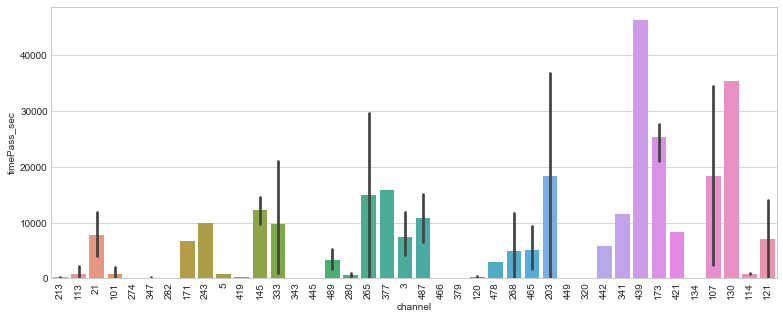

In [79]:
plt.figure(figsize=(13, 5))
g = sns.barplot(x="channel", y="timePass_sec", data=train_smp_withoutna)
g.set_xticklabels(labels = train_smp_withoutna["channel"].value_counts().index.tolist(), rotation=90)

In [80]:
count_byChannel = train_smp_withoutna[['channel','app']].groupby(['channel'], as_index=True).count()

[Text(0,0,'445'),
 Text(0,0,'379'),
 Text(0,0,'343'),
 Text(0,0,'21'),
 Text(0,0,'489'),
 Text(0,0,'171'),
 Text(0,0,'145'),
 Text(0,0,'347'),
 Text(0,0,'333'),
 Text(0,0,'268'),
 Text(0,0,'203'),
 Text(0,0,'265'),
 Text(0,0,'213'),
 Text(0,0,'134'),
 Text(0,0,'5'),
 Text(0,0,'465'),
 Text(0,0,'3'),
 Text(0,0,'130'),
 Text(0,0,'449'),
 Text(0,0,'280'),
 Text(0,0,'282'),
 Text(0,0,'341'),
 Text(0,0,'173'),
 Text(0,0,'442'),
 Text(0,0,'121'),
 Text(0,0,'120'),
 Text(0,0,'439'),
 Text(0,0,'243'),
 Text(0,0,'114'),
 Text(0,0,'113'),
 Text(0,0,'107'),
 Text(0,0,'274'),
 Text(0,0,'478'),
 Text(0,0,'466'),
 Text(0,0,'487'),
 Text(0,0,'101'),
 Text(0,0,'419'),
 Text(0,0,'377'),
 Text(0,0,'421'),
 Text(0,0,'320')]

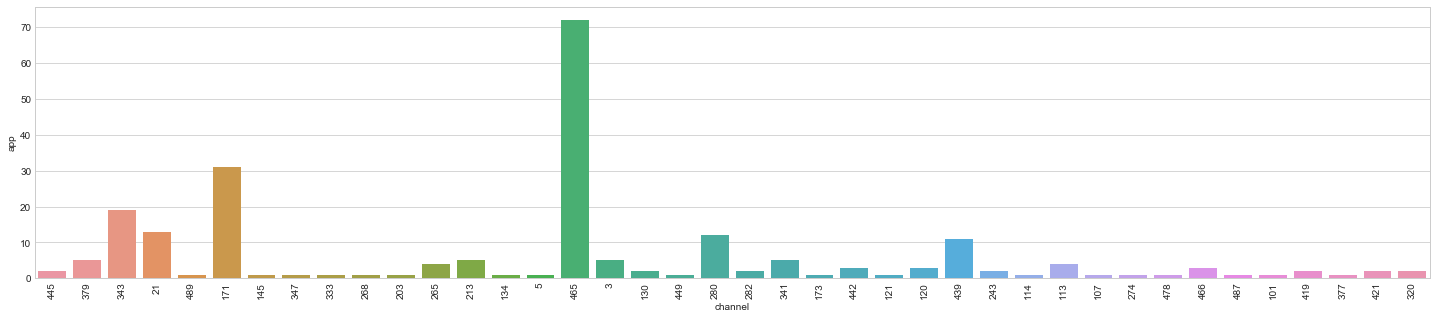

In [81]:
# Graphical representation betweetn number of app by channel
plt.figure(figsize=(25, 5))
g = sns.barplot(x=count_byChannel.index, y="app", data=count_byChannel)
g.set_xticklabels(labels = count_byChannel.index.value_counts().index.tolist(), rotation=90)

*Por tanto parece que existe una fuerte relación entre el canal y el tiempo que tarda en descargar la app*

#### Relación entre la IP y la suma de tiempo de descargas

In [82]:
train_smp_withoutna[['ip','channel','timePass_sec']].groupby(['ip'], as_index=True).mean().sort_values(['timePass_sec'],ascending=False).head(50).reset_index()

ip  channel  timePass_sec
0   307483    442.0       46341.0
1   112271    213.0       41366.0
2     6481    377.0       36726.0
3   253653    478.0       35299.0
4   344113    466.0       34414.0
5   113865    213.0       31132.0
6    85364     21.0       30548.0
7    48337    171.0       30121.0
8   199488    265.0       29568.0
9   211364    274.0       28134.0
10  120148    445.0       27616.0
11   96637    213.0       27550.0
12   11967    445.0       27548.0
13  325093     21.0       25735.0
14   34399    347.0       25084.0
15   56317    213.0       23263.0
16  344369    445.0       20960.0
17   62779    213.0       16685.0
18  243534    213.0       16678.0
19   24458     21.0       16473.0
20   97935     21.0       16395.0
21  180418    268.0       15743.0
22  177454    280.0       15040.0
23    7909    145.0       14902.0
24   18204    171.0       14827.0
25  311255    145.0       14403.0
26   46364    489.0       14039.0
27   32463    213.0       14015.0
28  330861     21.0       13508.0
29   40352    213.0       12959.0
30  182506    274.0       12498.0
31   89457    343.0       11696.0
32  210641    145.0       11681.0
33  258509    439.0       11476.0
34   83309    274.0       11145.0
35  233379    347.0       10961.0
36   12506     21.0       10801.0
37   95207    121.0        9835.0
38  186843    274.0        9213.0
39   57153    213.0        8768.0
40  344551    449.0        8382.0
41  161034    145.0        8320.0
42   79001    213.0        7483.0
43   69145    101.0        6930.0
44  137509     21.0        6833.0
45   86812    120.0        6706.0
46  120259    280.0        6565.0
47   40654     21.0        6530.0
48  184467    274.0        6428.0
49   29016    347.0        6324.0

_Relación entre la ip y la variable timePass_

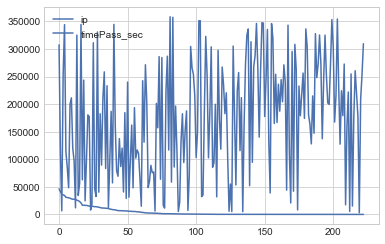

In [83]:
train_smp_withoutna[['ip','timePass_sec']].groupby(['ip'], as_index=True).mean().sort_values(['timePass_sec'],ascending=False).reset_index().plot()

In [84]:
train_smp_withoutna.ip.describe()

count       227.000000
mean     171715.154185
std      106667.455804
min        2948.000000
25%       81155.000000
50%      179080.000000
75%      256782.500000
max      358438.000000
Name: ip, dtype: float64

_A partir de las investigaciones realizadas cada no existen peticiones desde la misma ip en el dataset de ejemplo, lo cual complica el trabajo con el dataset de ejemplo..._

## Correlation between all variables


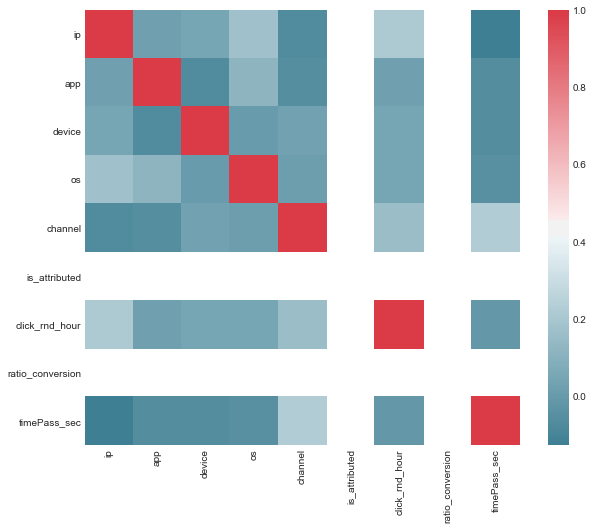

In [85]:

f, ax = plt.subplots(figsize=(10, 8))
corr = train_smp_withoutna.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [86]:
train_smp_withoutna.corr()

ip       app    device        os   channel  \
ip                1.000000  0.023187  0.047121  0.175618 -0.066273   
app               0.023187  1.000000 -0.067034  0.118395 -0.061293   
device            0.047121 -0.067034  1.000000  0.003587  0.034337   
os                0.175618  0.118395  0.003587  1.000000  0.013170   
channel          -0.066273 -0.061293  0.034337  0.013170  1.000000   
is_attributed          NaN       NaN       NaN       NaN       NaN   
click_rnd_hour    0.213180  0.023725  0.045311  0.046102  0.158428   
ratio_conversion       NaN       NaN       NaN       NaN       NaN   
timePass_sec     -0.127944 -0.063971 -0.063925 -0.047263  0.227365   

                  is_attributed  click_rnd_hour  ratio_conversion  \
ip                          NaN        0.213180               NaN   
app                         NaN        0.023725               NaN   
device                      NaN        0.045311               NaN   
os                          NaN        0.046102               NaN   
channel                     NaN        0.158428               NaN   
is_attributed               NaN             NaN               NaN   
click_rnd_hour              NaN        1.000000               NaN   
ratio_conversion            NaN             NaN               NaN   
timePass_sec                NaN       -0.009996               NaN   

                  timePass_sec  
ip                   -0.127944  
app                  -0.063971  
device               -0.063925  
os                   -0.047263  
channel               0.227365  
is_attributed              NaN  
click_rnd_hour       -0.009996  
ratio_conversion           NaN  
timePass_sec          1.000000

_Estas correlaciones nos muestran que existen corelaciónes entre la __app, os y device__. Algo que se puede considerar coherente, ya que algunas app son para un os determinado, y algunos os están asociadas a un tipo de device determinado, por ejemplo iOs con Apple_

_También encontrada correlación entre ip y os y timePass and channel_

## Studing unbalanced dataset

Inicialmente para realizar este estudio vamos a tomar muestras aleatorias sin remplazamiento de clicks con descarga y sin descarga y vamos a realizar el estudio bajo esa igualdad de condiciones. Cargamos de nuevo los datos:

In [87]:
#import first 10,000,000 rows of train and all test data
train = pd.read_csv('./input/train.csv', nrows=10000000)
test = pd.read_csv('./input/test.csv')

_Seleccionamos 18000 filas con clicks que conllevaron descarga de la app_

In [88]:
rows = np.random.choice(train[train['is_attributed']==1].index.values, 18000)
sampled_train_attributed = train.loc[rows]
sampled_train_attributed.describe()

ip           app        device            os       channel  \
count   18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean   124518.438278     31.674056     34.376889     21.622889    223.697389   
std     60616.813674     37.917408    223.099708     43.738273    107.212202   
min        25.000000      0.000000      0.000000      0.000000      0.000000   
25%     75673.750000     16.000000      1.000000     13.000000    145.000000   
50%    137771.500000     19.000000      1.000000     19.000000    213.000000   
75%    174809.250000     35.000000      1.000000     24.000000    274.000000   
max    212767.000000    481.000000   3522.000000    607.000000    498.000000   

       is_attributed  
count        18000.0  
mean             1.0  
std              0.0  
min              1.0  
25%              1.0  
50%              1.0  
75%              1.0  
max              1.0

_Seleccionamos 18000 filas con clicks que **no** conllevaron descarga de la app_

In [89]:
rows2 = np.random.choice(train[train['is_attributed']==0].index.values, 18000)
sampled_train_not_attributed = train.loc[rows2]
sampled_train_not_attributed.describe()

ip           app        device            os       channel  \
count   18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean    87710.337667     12.893444     32.068722     24.417889    253.466611   
std     55699.419675     16.208952    304.256418     61.210455    130.558258   
min        20.000000      1.000000      0.000000      0.000000      3.000000   
25%     42528.750000      3.000000      1.000000     13.000000    134.000000   
50%     82764.500000     12.000000      1.000000     18.000000    242.000000   
75%    121342.250000     15.000000      1.000000     19.000000    377.000000   
max    212773.000000    556.000000   3032.000000    607.000000    497.000000   

       is_attributed  
count        18000.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0

In [90]:
sampled_train = pd.concat([sampled_train_not_attributed, sampled_train_attributed], ignore_index=True)
sampled_train.describe()

ip           app        device            os       channel  \
count   36000.000000  36000.000000  36000.000000  36000.000000  36000.000000   
mean   106114.387972     22.283750     33.222806     23.020389    238.582000   
std     61049.455996     30.633097    266.780956     53.214215    120.379063   
min        20.000000      0.000000      0.000000      0.000000      0.000000   
25%     52549.250000      9.000000      1.000000     13.000000    135.000000   
50%    105666.500000     15.000000      1.000000     19.000000    213.000000   
75%    158089.000000     24.000000      1.000000     22.000000    317.000000   
max    212773.000000    556.000000   3522.000000    607.000000    498.000000   

       is_attributed  
count   36000.000000  
mean        0.500000  
std         0.500007  
min         0.000000  
25%         0.000000  
50%         0.500000  
75%         1.000000  
max         1.000000

**Ahora realizamos el estudio estadistico con respecto al conjunto *sampled_train* en el que se encuentra compensado el dataset**

Obtenemos los elementos únicos que existen en este subconjunto

In [91]:
t_unique = sampled_train.nunique()
t_unique

ip                 19230
app                  153
device               334
os                    99
channel              142
click_time         16581
attributed_time    10302
is_attributed          2
dtype: int64

### Estudio de variable IP

In [92]:
# unique counts ip with is_attributed == 1
temp_isa1 = sampled_train['ip'].value_counts().reset_index(name='counts')
temp_isa1.columns = ['ip', 'counts']
temp_isa1[:10]

ip  counts
0   73487     138
1   73516     127
2    5314      98
3    5348      85
4  100275      73
5  201182      68
6  105560      60
7  105475      53
8   95766      49
9  209663      49

_Bajo este dataset el número de veces máximo que aparece una ip  es 143_

**Representación del conjunto de ips que general descargas**

In [93]:
# librería para las representaciones gráficas
from cycler import cycler

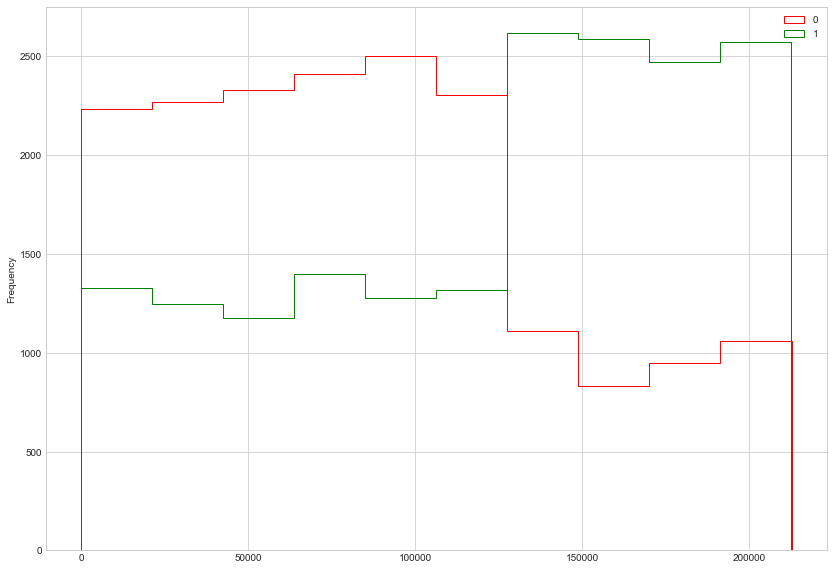

In [94]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
sampled_train_grouped = sampled_train.groupby('is_attributed')['ip']
sampled_train_grouped.plot(kind='hist', figsize=[14,10],histtype='step', legend=True)


plt.show()

_Llevando a cabo una división más granular:_

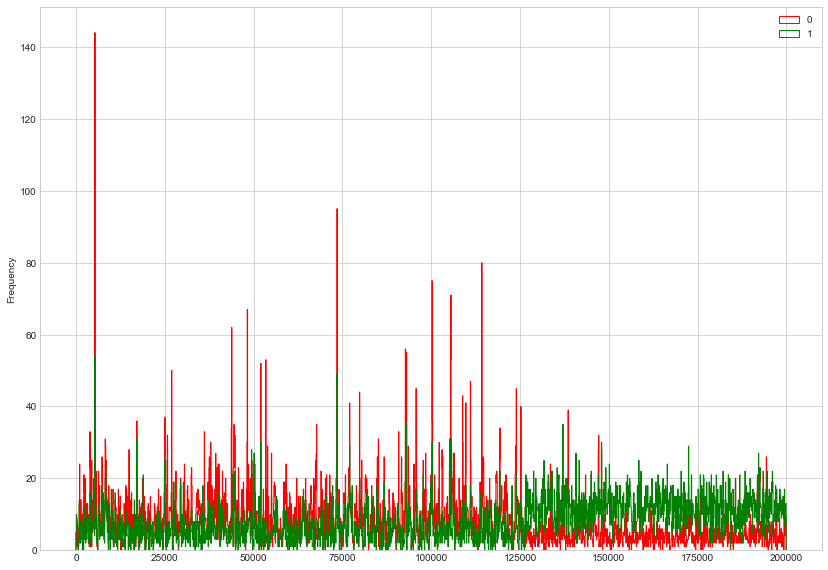

In [95]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
bin_values = np.arange(start=0, stop=200000, step=100)
sampled_train_grouped = sampled_train.groupby('is_attributed')['ip']
sampled_train_grouped.plot(kind='hist',bins=bin_values,figsize=[14,10],histtype='step', legend=True)


plt.show()

Por tanto, se puede observar que a partir de la ip 125000 suelen predominar las descargas de apps

### Estudio de variable APP

In [96]:
# counts clicks grouping by app
temp_app = sampled_train['app'].value_counts().reset_index(name='counts')
temp_app.columns = ['app', 'counts']
temp_app[:10].sort_values(['counts'],ascending=False)

app  counts
0   19    5171
1   35    3135
2    3    2734
3    2    2616
4    9    2601
5   12    2460
6   15    2412
7   18    2006
8   29    1509
9    8    1224

_El número de veces que aparece una app es 19_

**Representación del conjunto de ips que general descargas**

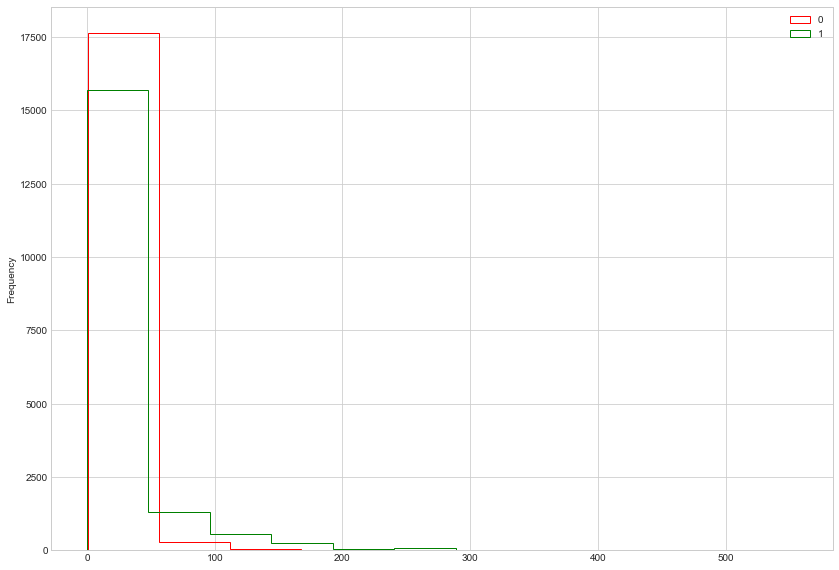

In [97]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
sampled_train_grouped = sampled_train.groupby('is_attributed')['app']
sampled_train_grouped.plot(kind='hist', figsize=[14,10],histtype='step', legend=True)


plt.show()

_Acontando en el intervalo donde conviven mayor cantidad de datos_

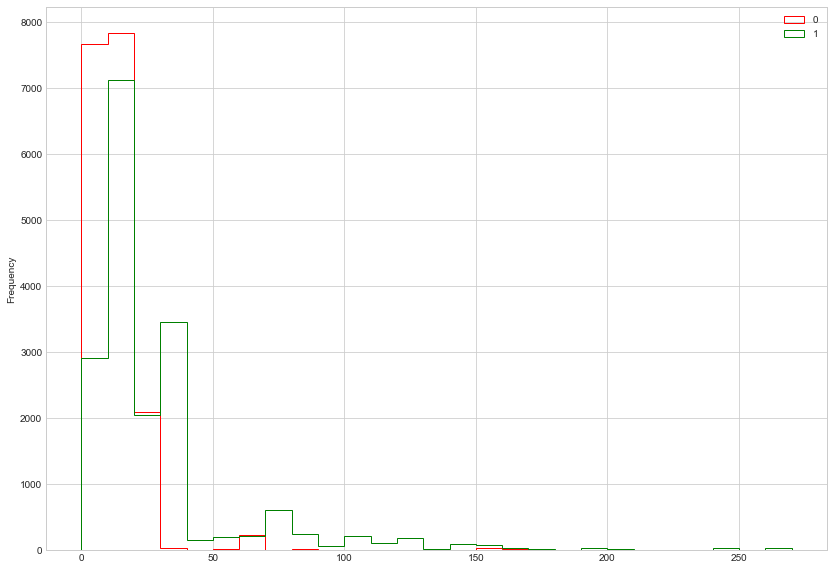

In [98]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
bin_values = np.arange(start=0, stop=280, step=10)
sampled_train_grouped = sampled_train.groupby('is_attributed')['app']
sampled_train_grouped.plot(kind='hist',bins=bin_values,figsize=[14,10],histtype='step', legend=True)


plt.show()

Como se puede observar anteriormente, en el intervalo (0,40) conviven la mayor cantidad de los datos

### Estudio de variable Device

In [99]:
# counts clicks grouping by device
temp_dev = sampled_train['device'].value_counts().reset_index(name='counts')
temp_dev.columns = ['device', 'counts_z']
temp_dev[:10].sort_values(['counts_z'],ascending=False)

device  counts_z
0       1     28969
1       0      4100
2       2       898
3    3032       181
4      40       132
5       6        94
6      16        72
7      18        57
8      21        46
9      88        43

_Verificar si existe una diferencia notable de dispositivos de un tipo determinado_

**Representación del conjunto de ips que general descargas**

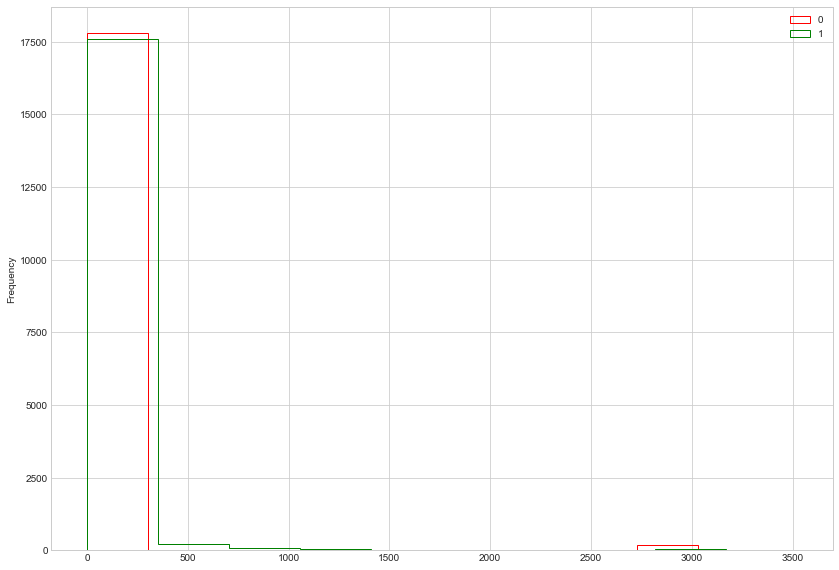

In [100]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
sampled_train_grouped = sampled_train.groupby('is_attributed')['device']
sampled_train_grouped.plot(kind='hist',figsize=[14,10],histtype='step', legend=True)


plt.show()

_Acotando en la en el intervalo donde conviven mayor cantidad de datos:_

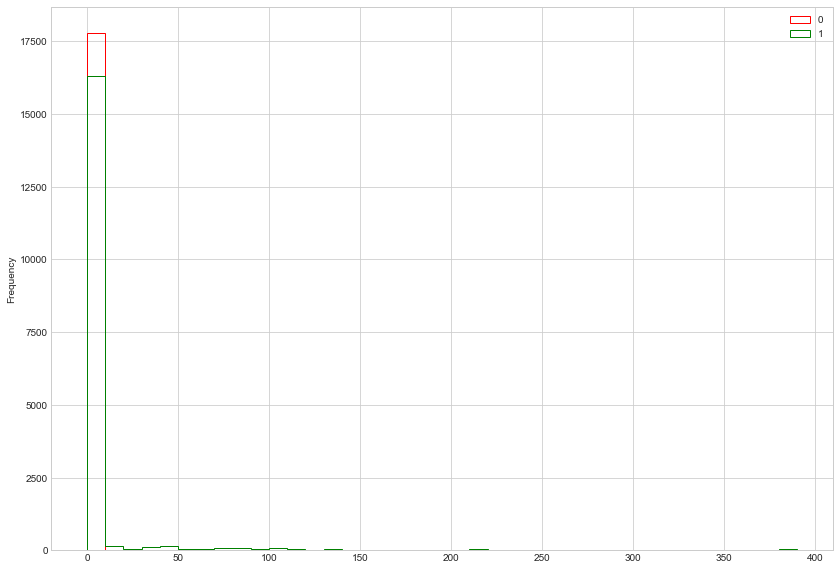

In [101]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
bin_values = np.arange(start=0, stop=400, step=10)
sampled_train_grouped = sampled_train.groupby('is_attributed')['device']
sampled_train_grouped.plot(kind='hist',bins=bin_values,figsize=[14,10],histtype='step', legend=True)


plt.show()


Por tanto, la mayor cantidad de los datos hacen referencia al dispositivo 0 y 1. Por tanto esta variable se encuentra bastante desbalanceada entre el conjunto de sus factores.

### Estudio de variable OS

In [102]:
# num of clicks by os
temp_os = sampled_train['os'].value_counts().reset_index(name='counts')
temp_os.columns = ['os', 'counts_a']
temp_os[:10].sort_values(['counts_a'],ascending=False)

os  counts_a
0  19      7839
1  13      6652
2  24      1899
3   0      1593
4  17      1585
5  18      1371
6  22      1295
7   6      1026
8   8       813
9  10       798

_Con un número máximo de 30 apariciones para el sistema operativo os_

**Representación del conjunto de ips que general descargas**

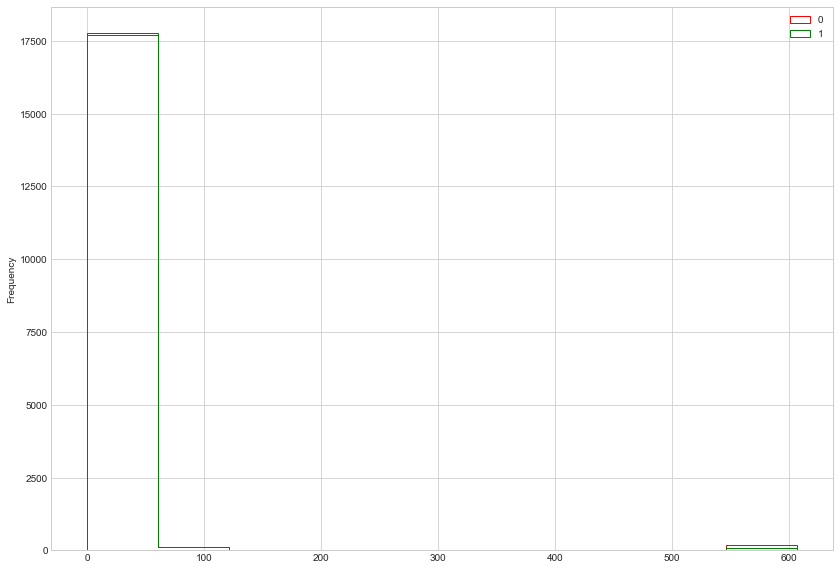

In [103]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
sampled_train_grouped = sampled_train.groupby('is_attributed')['os']
sampled_train_grouped.plot(kind='hist',figsize=[14,10],histtype='step', legend=True)


plt.show()


_Acotando en la en el intervalo donde conviven mayor cantidad de datos:_

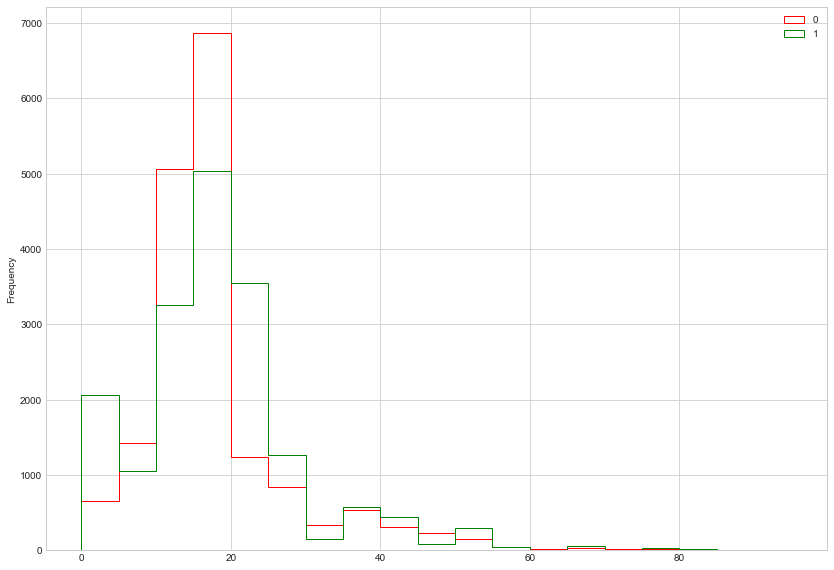

In [104]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
bin_values = np.arange(start=0, stop=100, step=5)
sampled_train_grouped = sampled_train.groupby('is_attributed')['os']
sampled_train_grouped.plot(kind='hist',bins=bin_values,figsize=[14,10],histtype='step', legend=True)


plt.show()


Como se puede observar en el intervalo (0,60) se abarca la mayor cantidad de datos que comprende esta variable. Podriamos considerar que el sistema operativo con más apariciones es Android, seguido de iOs...

### Estudio de variable channel

In [105]:
# num of clicks by channels
temp_ch = sampled_train['channel'].value_counts().reset_index(name='counts')
temp_ch.columns = ['channel', 'counts_b']
temp_ch[:10].sort_values(['counts_b'],ascending=False)

channel  counts_b
0      213      5325
1      274      1926
2      245      1510
3      134      1457
4       21      1348
5      101      1228
6      259      1157
7      145      1064
8      107       858
9      121       855

_Como se puede observar el número de clicks se encuentra muy distribuido entre los diferentes canales_

**Representación del conjunto de ips que general descargas**

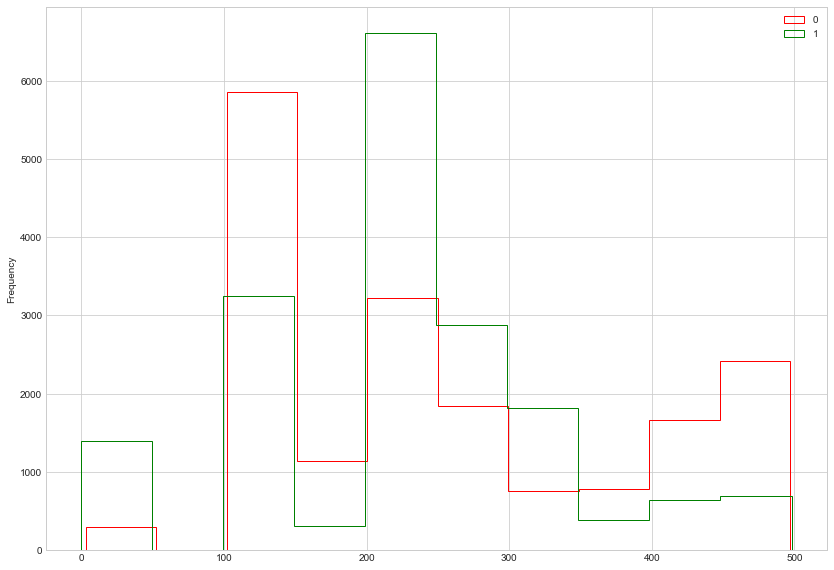

In [106]:
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g'])))
sampled_train_grouped = sampled_train.groupby('is_attributed')['channel']
sampled_train_grouped.plot(kind='hist',figsize=[14,10],histtype='step', legend=True)


plt.show()


Como resultado de las graficas anteriores se observa que el único punto donde pueden existir más diferencias es en el canal y en la ip, que tienen los datos más distribuidos por toda la población

### Realizando observaciones con respecto a variable tiempo de click

**(Pendiente)**

## Reducción de la dimensionalidad (PCA)

A continuación vamos a aplicar PCA, tecnica útilizada para reducir la dimensionalidad de un conjunto de datos. Está tecnica busca la proyección según la cual los datos queden mejor representados en término de mínimos cuadrados. (https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales).

Debido a la gran cantidad de datos no sabemos si resulta lógico aplicar esta técnica con esta enorme cantidad de datos, cuyos datos estan bastante dispersos, pero procedemos a aplicarlo.

Fuentes: https://plot.ly/ipython-notebooks/principal-component-analysis/

In [107]:
# Importamos librerías necesarias. Empleo de herramientas potentes de visualización. (https://plot.ly/)
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [108]:
tls.set_credentials_file(username='RaulSalazardeTorres', api_key='AFQsQwfL6RHpyS4yEqpt')

In [109]:
# Trabajando con un subconjunto de datos más pequeño
rows = np.random.choice(train[train['is_attributed']==1].index.values, 4000)
pca_train_attributed = train.loc[rows]


rows2 = np.random.choice(train[train['is_attributed']==0].index.values, 4000)
pca_train_not_attributed = train.loc[rows2]

pca_train = pd.concat([pca_train_not_attributed, pca_train_attributed], ignore_index=True)
pca_train.describe()

ip          app       device           os      channel  \
count    8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean   106785.536250    22.514500    34.374375    23.893750   238.489250   
std     61126.859328    30.028183   275.203454    57.549031   119.781627   
min        81.000000     0.000000     0.000000     0.000000     0.000000   
25%     53496.000000     9.000000     1.000000    13.000000   137.000000   
50%    106157.000000    18.000000     1.000000    19.000000   213.000000   
75%    159313.500000    24.000000     1.000000    22.000000   315.000000   
max    212767.000000   541.000000  3527.000000   649.000000   497.000000   

       is_attributed  
count    8000.000000  
mean        0.500000  
std         0.500031  
min         0.000000  
25%         0.000000  
50%         0.500000  
75%         1.000000  
max         1.000000

In [110]:
# Dividimos los datos, introduciendo en X los datos de entrada y la salida (is_attributed) en Y
X = pca_train.ix[:,0:5].values
y = pca_train.ix[:,7].values

/home/raul/anaconda3/envs/conda_3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [111]:
pca_train.head()

ip  app  device  os  channel           click_time attributed_time  \
0  113041    3       1  19      409  2017-11-06 23:03:31             NaN   
1  102156   18       1  13      107  2017-11-06 22:58:39             NaN   
2   26968   12       1  41      140  2017-11-06 21:45:11             NaN   
3   73933    9       1  19      215  2017-11-07 00:09:11             NaN   
4   21930    2       1  13      377  2017-11-06 16:42:28             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0

In [112]:
traces = []

legend = {0:False, 1:False, 2:False, 3:False, 4:True}

# Definición de colores a usar 
colors = {0: 'rgb(31, 119, 180)', 
          1: 'rgb(255, 127, 14)'
          }

# Dibujo del histograma de cada variable
for col in range(5):
    for key in colors:
        traces.append(Histogram(x=X[y==key, col], 
                        opacity=0.75,
                        xaxis='x%s' %(col+1),
                        marker=Marker(color=colors[key]),
                        name=key,
                        showlegend=legend[col]))

data = Data(traces)

# Layout que representa la figura
layout = Layout(barmode='overlay',
                xaxis=XAxis(domain=[0, 0.15], title='Ip'),
                xaxis2=XAxis(domain=[0.2, 0.35], title='App'),
                xaxis3=XAxis(domain=[0.4, 0.55], title='Device'),
                xaxis4=XAxis(domain=[0.6, 0.75], title='OS'),
                xaxis5=XAxis(domain=[0.8, 1], title='Channel'),
                yaxis=YAxis(title='count'),
                title='Distribution of the different Clicks features')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

Llevamos a cabo un proceso de estandarización de los datos, tarea la cual se debe de llevar a cabo para cualquier proceso de aprendizaje automático. Para ello continuamos con la transformación de los datos dentro de la unidad de escala (media = 0 y varianza=1):

In [113]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

/home/raul/anaconda3/envs/conda_3.6.2/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



### 1. Descomposición en autovectores y autovalores

#### Matriz de covarianza

El método que se suele emplear para PCA consiste en la descimposición de la matriz de covarianzas, en la que cada elemento representa la covarianza entre dos caracteristicas.

In [114]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Matriz de covarianza \n%s' %cov_mat)

Matriz de covarianza 
[[  1.00012502e+00   9.64970484e-02   1.04977078e-02   7.12316359e-03
    3.42833157e-04]
 [  9.64970484e-02   1.00012502e+00   7.34515896e-02   1.00344373e-01
   -1.44080219e-01]
 [  1.04977078e-02   7.34515896e-02   1.00012502e+00   6.59515366e-01
   -3.55497498e-02]
 [  7.12316359e-03   1.00344373e-01   6.59515366e-01   1.00012502e+00
   -4.12696317e-02]
 [  3.42833157e-04  -1.44080219e-01  -3.55497498e-02  -4.12696317e-02
    1.00012502e+00]]


Continuamos con la descomposición en autovectores y autovalores:

In [115]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Autovectores \n%s' %eig_vecs)
print('\nAutovalores \n%s' %eig_vals)

Autovectores 
[[  4.57422320e-02   4.21558131e-01  -8.17276198e-01  -3.90117388e-01
    8.02687201e-03]
 [  2.03398344e-01   6.62757922e-01   9.26917870e-03   7.19973522e-01
   -3.05493204e-02]
 [  6.84257182e-01  -1.74110159e-01  -2.85643222e-02  -6.25722454e-02
   -7.04802493e-01]
 [  6.88690055e-01  -1.49618899e-01  -1.90117700e-02  -2.65159471e-02
    7.08699972e-01]
 [ -1.18468894e-01  -5.74752571e-01  -5.75148964e-01   5.69936987e-01
   -3.21262701e-04]]

Autovalores 
[ 1.69260344  1.14450278  0.99980446  0.82370383  0.34001057]


#### Matriz de correlación

Sobre todo en el mundo de las finanzas, la **matriz de correlación** es más utilizada que la matriz de covarianzas. Debemos de tener en cuenta que la descomposición vectorial de la matriz de covarianza (si los datos se normalizaron) generan el mismo resultado que la descomposición vectorial de la matriz de correlación, puest que la matriz de correlación se comprende cono la matriz de covarianza normalizada. 

In [116]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Autovectores \n%s' %eig_vecs)
print('\nAutovalores \n%s' %eig_vals)

Autovectores 
[[  4.57422320e-02   4.21558131e-01  -8.17276198e-01  -3.90117388e-01
    8.02687201e-03]
 [  2.03398344e-01   6.62757922e-01   9.26917870e-03   7.19973522e-01
   -3.05493204e-02]
 [  6.84257182e-01  -1.74110159e-01  -2.85643222e-02  -6.25722454e-02
   -7.04802493e-01]
 [  6.88690055e-01  -1.49618899e-01  -1.90117700e-02  -2.65159471e-02
    7.08699972e-01]
 [ -1.18468894e-01  -5.74752571e-01  -5.75148964e-01   5.69936987e-01
   -3.21262701e-04]]

Autovalores 
[ 1.69239186  1.14435972  0.99967948  0.82360087  0.33996806]


#### Descomposición en vectores singulares

In [117]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[ -4.57422320e-02,   4.21558131e-01,  -8.17276198e-01,
         -3.90117388e-01,   8.02687201e-03],
       [ -2.03398344e-01,   6.62757922e-01,   9.26917870e-03,
          7.19973522e-01,  -3.05493204e-02],
       [ -6.84257182e-01,  -1.74110159e-01,  -2.85643222e-02,
         -6.25722454e-02,  -7.04802493e-01],
       [ -6.88690055e-01,  -1.49618899e-01,  -1.90117700e-02,
         -2.65159471e-02,   7.08699972e-01],
       [  1.18468894e-01,  -5.74752571e-01,  -5.75148964e-01,
          5.69936987e-01,  -3.21262701e-04]])

### 2. Seleccionando componentes principales

El objetivo que perseguimos en PCA es reducir la dimensionalidad del espacio de trabajo original. Los autovectores unicamente definen la dirección de los nuevos ejes, debemos de comprobar que tiene el mismo tamaño 1, a partir de la siguiente comprobación:

In [118]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Todo ok!')

Todo ok!


Para decidir que autovectores podemos borrar sin perder demasiado información, necesitamos tener en cuenta los autovalores, de manera que los autovectores con autovalores más bajos tiene menos información sobre la distribucción de los datos, de manera que podrían ser eliminados.

In [119]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Autovalores en orden descendente:')
for i in eig_pairs:
    print(i[0])

Autovalores en orden descendente:
1.69239186181
1.14435971978
0.999679482106
0.823600871384
0.339968064929


Tras el resultado anterior, la pregunta sería: ¿Cuantos componentes podemos elegir para definir nuestro subespacio de caracteristicas?  Para ello se va utilizar la medidad de la varianza esplicada, la cual nos índica cuanta información (varianza) puede atribuirse a cada una de las componentes princiales.

In [120]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,6)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,6)], 
        y=cum_var_exp,
        name='Varianza explicada acumuladamente')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Varianza explicada en porcentaje'),
        title='Varianza explicada por las diferentes componentes')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

Como se puede observar en la gráfica anterior, con las 4 primeras componentes cubririamos el 95,5% de la información. La construcción de la proyección en esta matriz se utilizada para transformar el dataset en nuevo subespacio de caracteristicas. A continuación, vamos a reducir el 5-d espacio de caracteristicas a un 4-d espacio de caracteristicas:

In [121]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(5,1), 
                      eig_pairs[1][1].reshape(5,1),
                      eig_pairs[2][1].reshape(5,1),
                      eig_pairs[3][1].reshape(5,1)))

print('Matriz W:\n', matrix_w)

Matriz W:
 [[ 0.04574223  0.42155813 -0.8172762  -0.39011739]
 [ 0.20339834  0.66275792  0.00926918  0.71997352]
 [ 0.68425718 -0.17411016 -0.02856432 -0.06257225]
 [ 0.68869006 -0.1496189  -0.01901177 -0.02651595]
 [-0.11846889 -0.57475257 -0.57514896  0.56993699]]


## Importancia de características

In [122]:
# Importamos las librerías que necesitamos para el análisis
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#### Recursive Feature Elimination (RFE)

Usando el **método RFE** (Eliminación de caracteristicas recursivas). Este algoritmo funciona eliminando recursivamente atributos y construyendo un modelo en base  al resto. Usa el valor de accuracy para identificar que combinación de atributos constribuye más en la predicción de la variable objetivo.

In [123]:
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True False  True  True]
[3 1 2 1 1]


Según el resultado anterior, si dijeramos de quedarnos con dos atributos nos recomienda quedarnos con el primero y el último, es decir, la ip y el canal.

#### Feature Importance

Este método utiliza conjunto de arboles de decisiones (como Random Forest o Extra Trees) para obtener la importancia relativa de cada atributo. Vamos a utilizar un conjunto **Extra Tree** para mostrar la importancia relativa de cada caracteristica.

In [124]:
# Importamos las librerías requeridas
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

In [125]:
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.2642041   0.30020277  0.053055    0.13341142  0.24912671]


Representación gráfica de los resultados:

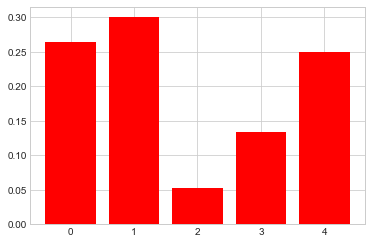

In [126]:
import pylab as pl
s = np.array(model.feature_importances_)
plt.bar(np.arange(len(s)),s)
plt.show()

Como se puede observar en la gráfica anterior, los atributos con más importancia son app, ip y canal, por orden de importancia. Quedando OS y device, especialmente **OS con una relevancia bastante inferior**.